**Limpieza de datos**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [35]:
df = pd.read_csv('data/CAvideos_cc50_202101.csv')

In [36]:
# Eliminacion de duplicados
df = df.sort_values('views', ascending=False).drop_duplicates(subset='video_id', keep='first').reset_index(drop=True)
duplicate_counts = df['video_id'].value_counts()
print('Número total de videos repetidos:', sum(duplicate_counts[duplicate_counts > 1] - 1))

Número total de videos repetidos: 0


In [37]:
# Rellenar valores none para la columna tags
df['tags'] = df['tags'].replace('[none]', 'No tags')

# Rellenar los valores nulos de la columna description
df['description'] = df['description'].fillna('No description')

In [38]:
# Formatear fechas
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

**Preprocesamiento**

In [39]:
# Asociar la columna category_id con su nombre respectivo
with open('data/CA_category_id.json', 'r') as f:
    categorias_data = json.load(f)
    
category_mapping = {
    int(item['id']): item['snippet']['title']
    for item in categorias_data['items']
    if 'snippet' in item and 'title' in item['snippet']
}

df['category_id'] = df['category_id'].astype(int)

df['category_id'] = df['category_id'].map(category_mapping)

df.rename(columns={'category_id': 'category'}, inplace=True)

In [40]:
df['category'].isna().sum()

np.int64(49)

In [41]:
df['category'] = df['category'].fillna('Unknown')

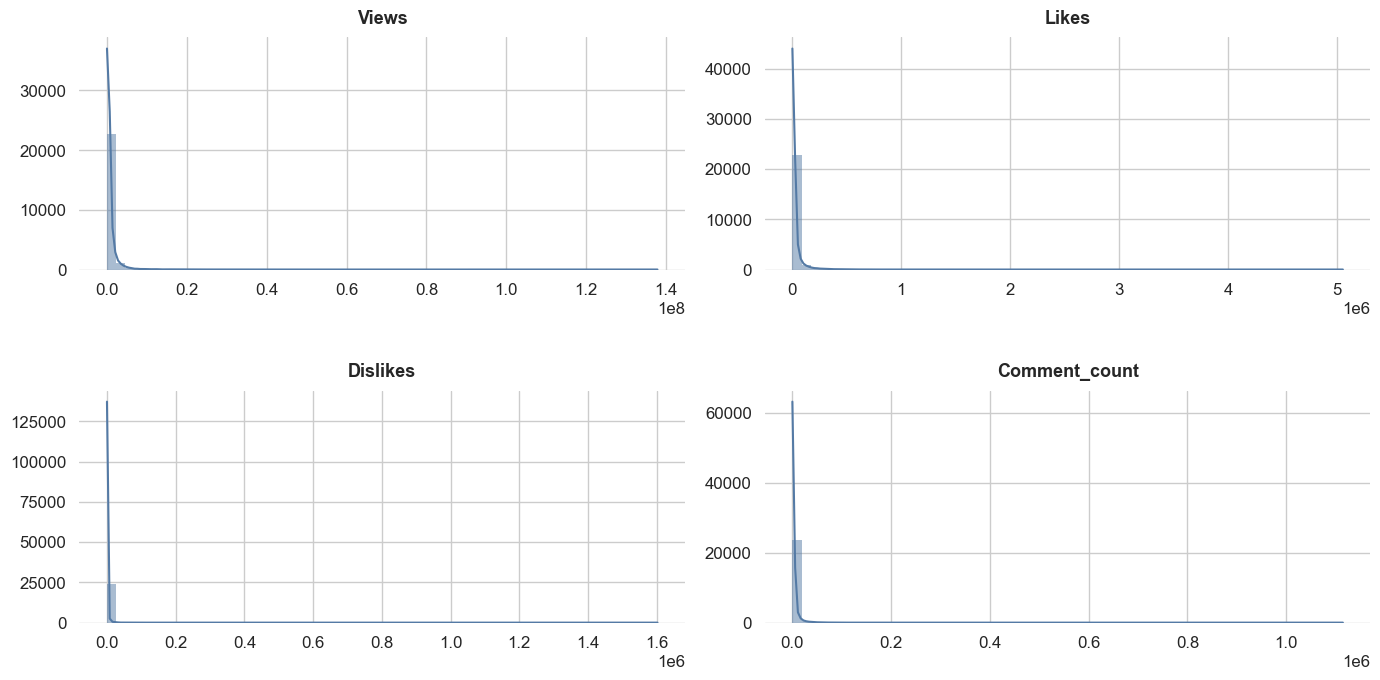

In [42]:
# Identificar outliers
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams.update({
    'axes.edgecolor': 'white',
    'axes.linewidth': 0.8,
    'figure.facecolor': 'white',
    'axes.titlesize': 13,
    'axes.titleweight': 'semibold'
})

cols = ['views', 'likes', 'dislikes', 'comment_count']

plt.figure(figsize=(14, 7))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=60, kde=True, color="#547aa5", edgecolor='none')
    plt.title(col.capitalize(), pad=10)
    plt.xlabel("")
    plt.ylabel("")
    sns.despine(left=True, bottom=True)

plt.tight_layout(h_pad=2.5)
plt.show()


**Construccion de nuevos datos**

In [43]:
# engagement_rate
df["engagement_rate"] = (df["likes"] + df["comment_count"]) / df["views"]

In [44]:
#  days_until_trending
df["publish_time"] = pd.to_datetime(df["publish_time"]).dt.tz_localize(None)
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m")

df["days_until_trending"] = (df["trending_date"] - df["publish_time"]).dt.days

In [45]:
df = df[df["days_until_trending"] >= 0]

In [46]:
# like_ratio
df["like_ratio"] = df["likes"] / (df["likes"] + df["dislikes"] + 1)

In [47]:
# Variable dependiente (target)

# Condición 1: vistas
cond1 = (df["views"] >= 500_000).fillna(False)

# Condición 2: engagement (top 20%)
quantile_80 = df["engagement_rate"].quantile(0.8)
cond2 = (df["engagement_rate"] >= quantile_80).fillna(False)

# Condición 3: tiempo hasta hacerse tendencia
cond3 = (df["days_until_trending"] <= 3).fillna(False)

# Suma booleana: al menos 2 condiciones verdaderas
df["is_viral"] = (cond1.astype(int) + cond2.astype(int) + cond3.astype(int) >= 2).astype(int)

print(df["is_viral"].value_counts())


is_viral
0    12851
1    10607
Name: count, dtype: int64


In [48]:
df.to_csv('data/CAvideos_cc50_202101_cleaned.csv', index=False)
print('Dimensiones del dataset:', df.shape)

Dimensiones del dataset: (23458, 24)
